#Transfer Learning using Inception-v3 for Image Classification
This example uses the three channel Intraventricular Dataset. Takes ~1hr to run fully.

We are training with Inception-v3 with a classifer network amended to the end. The Inception-v3 network lacks its two last layers for better performance and integration with the classifer network.

The train/validation split is 50/50 between healthy and one (1) hemorrhage type.


# Start Up Cells

**Import Libraries**

In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from pathlib import Path
!pip install pydicom
import pydicom
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image

     |████████████████████████████████| 1.9MB 18.0MB/s 


# Importing and establishing new dataset

**Import Adequate Dataset from private Google Drive**
Need to first mount drive to Google Colab director using appropriate authentication token from provided link.

Unzip into /tmp 

In [ ]:
# Get zip files stored in shared google drive
from google.colab import drive
drive.mount('/content/drive')

local_zip = '/content/drive/Shareddrives/ECE 431 Team Project/Zipped Data/processed_dataset_intraventricular_c3.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

Mounted at /content/drive


**Setting up directory system to later be used for constructing neural network.**

In [ ]:
base_dir = '/tmp/processed_dataset_intraventricular_c3'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training healthy pictures
train_healthy_dir = os.path.join(train_dir, 'healthy')

# Directory with our training intraventricular pictures
train_intrap_dir = os.path.join(train_dir, 'intraventricular')

# Directory with our validation healthy pictures
validation_healthy_dir = os.path.join(validation_dir, 'healthy')

# Directory with our validation intraventricular pictures
validation_intrap_dir = os.path.join(validation_dir, 'intraventricular')

**Examples of images from healthy and hemorrhaged CT scans.**

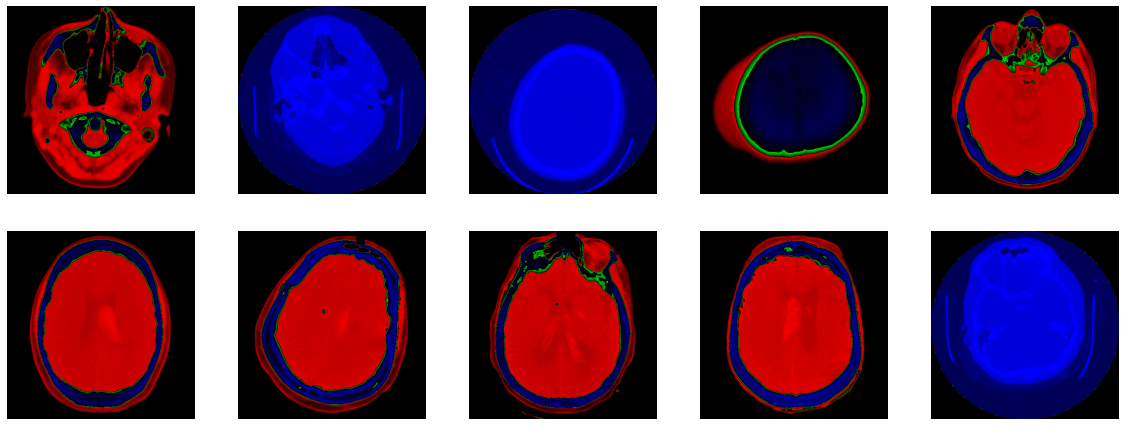

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
nrows = 5
ncols = 5

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_healthy_fnames = os.listdir( train_healthy_dir )
train_intrap_fnames = os.listdir( train_intrap_dir )


next_healthy_pix = [os.path.join(train_healthy_dir, fname) 
                for fname in train_healthy_fnames[ pic_index-5:pic_index] 
               ]

next_intrap_pix = [os.path.join(train_intrap_dir, fname) 
                for fname in train_intrap_fnames[ pic_index-5:pic_index]
               ]

for i, img_path in enumerate(next_healthy_pix+next_intrap_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

# **Import the Inception model and setup NN**

We are going to use all the layers in the model except for the last fully connected layer and a single layer right before that.

In [ ]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

last_layer = pre_trained_model.get_layer('mixed7') #Only use layers including and above 'mixed7'
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

for layer in pre_trained_model.layers:
  layer.trainable = False

87916544/87910968 [==============================] - 0s 0us/step
last layer output shape:  (None, 7, 7, 768)


**Define a Callback class that stops training once accuracy reaches 99% or gets below 45%**

A very high accuracy at the first few epochs may suggest an error in the dataset. The same may be true for a network yielding below 45% accuracy. Statistically, a classifer should have a 50% accuracy if there are only two classes and they decided randomly. A 2-class classifer getting to below 45% would suggest errors in the code or dataset.

In [ ]:
from sklearn.metrics import roc_auc_score

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('acc')>0.9900):
      print("\nReached 99% accuracy so cancelling training!")
      self.model.stop_training = True
    if(logs.get('acc')<0.4500):
      print("\nReached <45% accuracy so cancelling!!!")
      print("\FIX Dataset/Code TT")
      self.model.stop_training = True
    

We use binary_crossentropy as the loss metric as we have 2 target classes (it's a binary classification problem)

Our optimizer is **RMSprop** with a learning rate of **0.00009** (We can experiment with this; Adam and Adagrad optimizers would also work well)

-Tejanirla

**Rescale the Images**

The data generators read pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images.

Input data to the neural networks should be normalized to aid in processing. We will preprocess our images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).

In Keras this can be done via the **keras.preprocessing.image.ImageDataGenerator** class using the **rescale** parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs: fit_generator, evaluate_generator, and predict_generator.

-Tejanirla



We also perform **Image Augmentation** where we change the images a bit by rotating them, squashing them, etc.

We can implement this using the ImageDataGenerator Class



```
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
```


**Some options that are available:**


*   rotation_range is a value in degrees (0–180), a range within which to randomly rotate pictures.
*   width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
*   shear_range is for randomly applying shearing transformations
*   zoom_range is for randomly zooming inside pictures
*   horizontal_flip is for randomly flipping half of the images horizontally. This is relevant when there are no assumptions of horizontal assymmetry (e.g. real-world pictures)
*   fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift

-Tejanirla

# Training Network

In [ ]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.00009), 
              loss = 'binary_crossentropy', 
              metrics = ['acc',
                         'AUC',
                         tf.keras.metrics.SensitivityAtSpecificity(0.0, name="spe00"),
                         tf.keras.metrics.SensitivityAtSpecificity(0.1, name="spe01"),
                         tf.keras.metrics.SensitivityAtSpecificity(0.2, name="spe02"),
                         tf.keras.metrics.SensitivityAtSpecificity(0.3, name="spe03"),
                         tf.keras.metrics.SensitivityAtSpecificity(0.4, name="spe04"),
                         tf.keras.metrics.SensitivityAtSpecificity(0.5, name="spe05"),
                         tf.keras.metrics.SensitivityAtSpecificity(0.6, name="spe06"),
                         tf.keras.metrics.SensitivityAtSpecificity(0.7, name="spe07"),
                         tf.keras.metrics.SensitivityAtSpecificity(0.8, name="spe08"),
                         tf.keras.metrics.SensitivityAtSpecificity(0.9, name="spe09"),
                         tf.keras.metrics.SensitivityAtSpecificity(1.0, name="spe10")])
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

callbacks = myCallback()
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 2,
            callbacks=[callbacks])

last layer output shape:  (None, 7, 7, 768)
Found 8000 images belonging to 2 classes.
Found 8000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
100/100 - 68s - loss: 0.6312 - acc: 0.7000 - auc: 0.7655 - spe00: 1.0000 - spe01: 0.9844 - spe02: 0.9647 - spe03: 0.9335 - spe04: 0.8929 - spe05: 0.8524 - spe06: 0.7963 - spe07: 0.6996 - spe08: 0.5728 - spe09: 0.3919 - spe10: 0.0000e+00 - val_loss: 0.4334 - val_acc: 0.7950 - val_auc: 0.9120 - val_spe00: 1.0000 - val_spe01: 1.0000 - val_spe02: 0.9980 - val_spe03: 0.9939 - val_spe04: 0.9836 - val_spe05: 0.9734 - val_spe06: 0.9508 - val_spe07: 0.9078 - val_spe08: 0.8791 - val_spe09: 0.7643 - val_spe10: 0.0348
Epoch 2/100
100/100 - 27s - loss: 0.4940 - acc: 0.7780 - auc: 0.8519 - spe00: 1.0000 - spe01: 0.9959 - spe02: 0.9919 - spe03: 0.9827 - spe04: 0.9665 - spe05: 0.9289 - spe06: 0.8964 - spe07: 0.8437 - spe08: 0.7462 - spe09: 0.5543 - spe10: 0.0335 - val_loss: 0.3856 - val_acc: 0.8170 - val_auc: 0.9081 - val_spe00: 1.0000 - val_spe01: 1.0000 - val_spe02: 1.0000 - val_spe03: 1.0000 - val_spe04: 0.9939 - val_spe05: 0.9838 - val_spe06: 0.9656 - val_spe07: 0.9109 - val_spe08: 0.8

**Saving variables for Loss, Accuracy, ROC, AUC**

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
auc = history.history['auc']
val_auc = history.history['val_auc']
spe00 = history.history['spe00']
spe01 = history.history['spe01']
spe02 = history.history['spe02']
spe03 = history.history['spe03']
spe04 = history.history['spe04']
spe05 = history.history['spe05']
spe06 = history.history['spe06']
spe07 = history.history['spe07']
spe08 = history.history['spe08']
spe09 = history.history['spe09']
spe10 = history.history['spe10']
val_spe00 = history.history['val_spe00']
val_spe01 = history.history['val_spe01']
val_spe02 = history.history['val_spe02']
val_spe03 = history.history['val_spe03']
val_spe04 = history.history['val_spe04']
val_spe05 = history.history['val_spe05']
val_spe06 = history.history['val_spe06']
val_spe07 = history.history['val_spe07']
val_spe08 = history.history['val_spe08']
val_spe09 = history.history['val_spe09']
val_spe10 = history.history['val_spe10']

# Sensitivity at Specificity thresholds of 1.0 to 0.0. Ordered for FPR
# Indexed as train_spe[specificity_threshold][epoch]. 
# Typecasted to np.array for accessible indicies
train_spe = np.array([spe10, spe09, spe08, spe07, spe06, spe05, spe04, spe03, spe02, spe01, spe00])
val_spe = np.array([val_spe10, val_spe09, val_spe08, val_spe07, val_spe06, val_spe05, val_spe04, val_spe03, val_spe02, val_spe01, val_spe00])
# Specificity X vector for plotting sensitivity vs specificity
spe_vec = np.linspace(0.0,1.0,11)

**Plotting Loss, Accuracy, ROC, AUC for the training and validation data**
There will be readouts for the max validation accuracy and max validation AUC.

Max Validation Accuracy: 0.9010000228881836 at Epoch: 55
     Max Validation AUC: 0.9633343815803528 at Epoch: 48


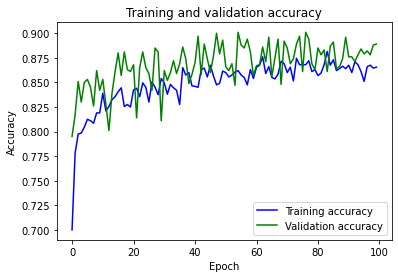

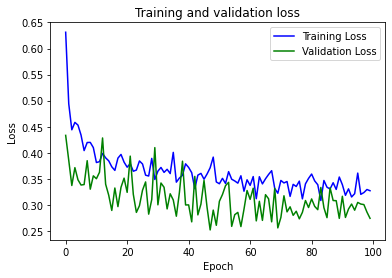

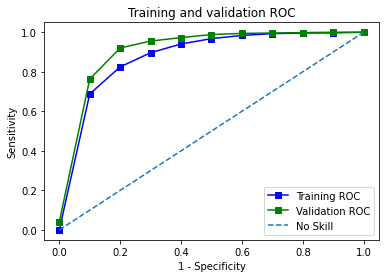

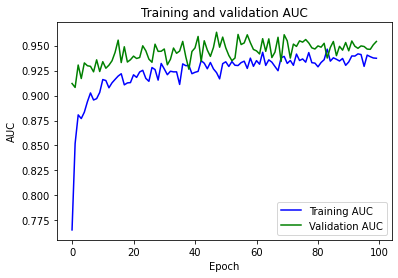

In [ ]:
import matplotlib.pyplot as plt

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
print('Max Validation Accuracy:', max(val_acc),'at Epoch:',val_acc.index(max(val_acc)) + 1)

plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.figure()
plt.plot(spe_vec, train_spe[:,5], 'sb-', label='Training ROC')
plt.plot(spe_vec, val_spe[:,5], 'sg-', label='Validation ROC',)
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
plt.title('Training and validation ROC')
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.legend()

plt.figure()
plt.plot(epochs, auc, 'b', label='Training AUC')
plt.plot(epochs, val_auc, 'g', label='Validation AUC')
plt.title('Training and validation AUC')
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
print('     Max Validation AUC:', max(val_auc),'at Epoch:',val_auc.index(max(val_auc)) + 1)

plt.plot()

plt.show()

# Save existing variables from current network outputs
Save variable state (as dictionary) to pickle format.
Requires private Google Drive to be mounted.

In [ ]:
# Save to drive
# SAVE AS DDMMYYYY_HemType_Channel
import pickle

saved_map = {
    'acc':acc, 'val_acc':val_acc, 'loss':loss, 'val_loss':val_loss, 'auc':auc, 'val_auc':val_auc, 'train_spe':train_spe, 'val_spe':val_spe
}

print("05072021_intraventricular_c3")
user_filename = input()
user_filename = "/content/drive/Shareddrives/ECE 431 Team Project/Colab NBs & Test Results/Variable States/" + user_filename + ".pickle"
with open(user_filename, 'wb') as f:
  pickle.dump(saved_map, f)

05072021_intraventricular_C3
05072021_intraventricular_C3
